In [2]:
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import emd
from scipy.ndimage import gaussian_filter1d
from scipy.fft import fft, fftfreq
# from get_signals import get_signals

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Расчет значений дополнительных физиологических параметров (раздел отчета 6.2)
## Содержание jupyter notebook (ссылки): <a id="contents"></a>
1. [Пульс и вариабельность сердечного ритма](#heart)
2. [Частота дыхания](#breath)
3. [Вариабельность артериального давления](#pressure)
4. [Артериальная и венозная сатурация](#sat)
5. [Основные параметры оксигенации и восстановление абсолютных значений](#recover)
6. [Расчет остальных показатели работы кровеносной системы с использованием значений оксигенации](#all_others)

**Загрузка данных.**

In [3]:
filename = 'data/hypothenar_data.xlsx'
r_1 = 1.62
r_2 = 2.22
lmbd_1 = 692
lmbd_2 = 834
sto2, d_hb, d_hbo, d_hhb, d_thb, time, d_mua_lmbd1, d_mua_lmbd2 = get_signals(filename, r_1, r_2, lmbd_1, lmbd_2)

In [4]:
df_real = pd.read_excel('data/Diodes1357_HbUa.xlsx')
thb_real = df_real["THC A"].values
hhb_real = df_real[" [De Oxy] A"].values
hbo_real = df_real[" [Oxy] A"].values

<a id='heart'></a>
### Вычисление пульса и вариабельности сердечного ритма
[Вернуться к содержанию](#contents)

**На небольшом участке сигнала**

Поиск количества возрастающих фронтов пульсовой волны как количества локальных максимумов производной сигнала D_Hb, соответствующих точкам перегиба на возрастающих фронтах. Локальные максимумы первой производной были найдены как нули сигнала, полученного путем взятия производной от сглаженной первой производной.

Для улучшения точности алгоритма из сигнала были удалены EMD-уровни, соответствующие иным компонентам, кроме пульсовой.

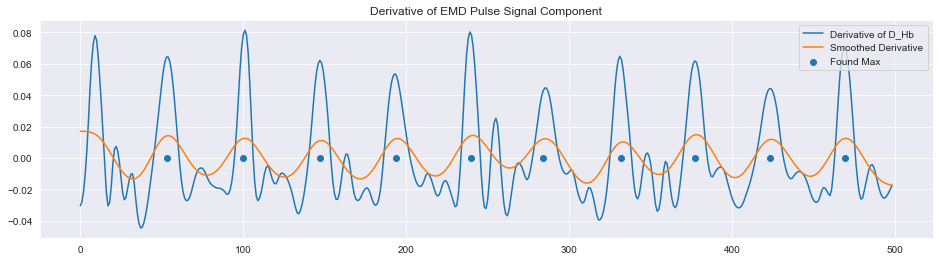

In [5]:
imf = emd.sift.sift(d_hb)
levels = (imf[:, 2]+imf[:, 3])[90*50:100*50]
dy = np.diff(levels)
ddy = np.diff(gaussian_filter1d(dy, 10))
pairs = []
zeros = []
first = -1
second = -1
for i in range(len(ddy) - 1):
    if ddy[i] <= 0 and ddy[i + 1] >= 0:
        first = i
    elif ddy[i] >= 0 and ddy[i + 1] <= 0 and first != -1:
        pairs.append((first, i))
        zeros.append(i)
        first = -1
figure, axis = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(dy)
plt.plot(gaussian_filter1d(dy, 10))
plt.scatter(zeros, np.zeros(len(zeros)))
plt.legend(["Derivative of D_Hb", "Smoothed Derivative", "Found Max"])
plt.title("Derivative of EMD Pulse Signal Component")
plt.show()

Вычисление пульса по средней разности между моментами локальных максимумов

In [6]:
pulse = 60 / (((zeros[-1] - zeros[0]) / 50) / (len(zeros) - 1))
print("Количество ударов в минуту:", np.round(pulse, 1))

Количество ударов в минуту: 64.9


Вычисление вариабельности сердечного ритма как последовательности разностей интервалов времени между соседними пульсовыми колебаниями

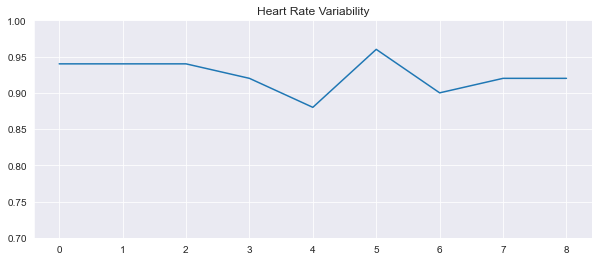

In [7]:
diffs = []
for i in range(len(zeros)-1):
    diffs.append((zeros[i+1] - zeros[i]) / 50)
figure, axis = plt.subplots(1, 1, figsize=(10, 4))
plt.plot(diffs)
plt.ylim([0.7, 1])
plt.title("Heart Rate Variability")
plt.show()

**Вычисление пульса и его вариабельности для всего сигнала**

Производная пульсовой компоненты

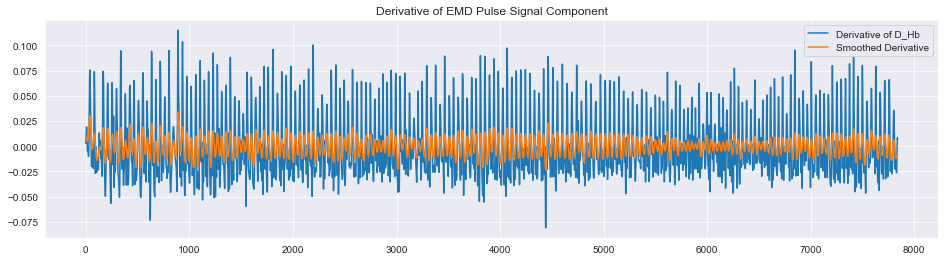

In [8]:
imf = emd.sift.sift(d_hb)
levels = imf[:, 2]+imf[:, 3]
dy = np.diff(levels)
ddy = np.diff(gaussian_filter1d(dy, 10))
pairs = []
zeros = []
first = -1
second = -1
for i in range(len(ddy) - 1):
    if ddy[i] <= 0 and ddy[i + 1] >= 0:
        first = i
    elif ddy[i] >= 0 and ddy[i + 1] <= 0 and first != -1:
        pairs.append((first, i))
        zeros.append(i)
        first = -1
figure, axis = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(dy)
plt.plot(gaussian_filter1d(dy, 10))
plt.legend(["Derivative of D_Hb", "Smoothed Derivative"])
plt.title("Derivative of EMD Pulse Signal Component")
plt.show()

Средний пульс на всем сигнале

In [9]:
pulse = 60 / (((zeros[-1] - zeros[0]) / 50) / (len(zeros) - 1))
print("Количество ударов в минуту на всем сигнале:", np.round(pulse, 1))

Количество ударов в минуту на всем сигнале: 71.5


График вариабельности сердечного ритма

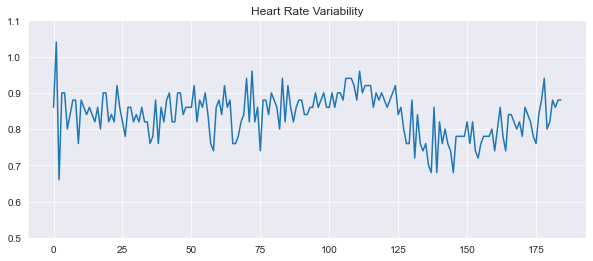

In [10]:
diffs = []
for i in range(len(zeros)-1):
    diffs.append((zeros[i+1] - zeros[i]) / 50)
figure, axis = plt.subplots(1, 1, figsize=(10, 4))
plt.plot(diffs)
plt.ylim([0.5, 1.1])
plt.title("Heart Rate Variability")
plt.show()

Вычисление пульса скользящим окном по 10 сокращений

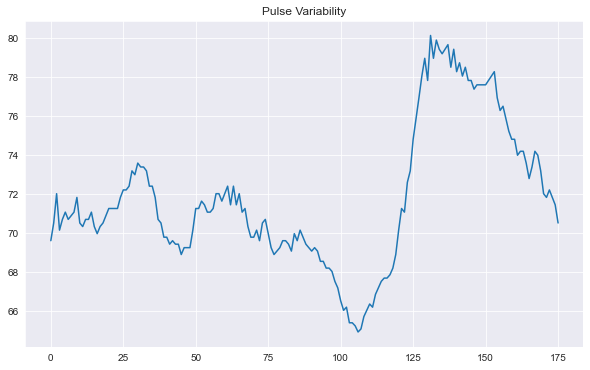

In [11]:
def find_pulse(start, end):
    return 60 / (((zeros[end-1] - zeros[start]) / 50) / (end-start-1))

num_points = 10
total_pulse = []
for i in range(len(zeros) - num_points):
    total_pulse.append(find_pulse(i, i+num_points))


figure, axis = plt.subplots(1, 1, figsize=(10, 6))
plt.plot(total_pulse)
plt.title("Pulse Variability")
plt.show()

<a id='breath'></a>
### Вычисление частоты дыхания
[Вернуться к содержанию](#contents)

Аналогичное вычисление можно провести для поиска частоты дыхания, но нужно использовать другие уровни EMD, соответствующие диапазону частот дыхания

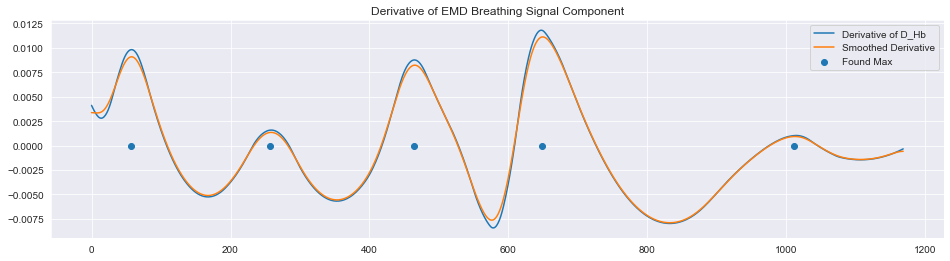

In [12]:
imf = emd.sift.sift(d_hb)
levels = (imf[:, 4]+imf[:, 5])[90*50+2170:]
dy = np.diff(levels)
ddy = np.diff(gaussian_filter1d(dy, 10))
pairs = []
zeros = []
first = -1
second = -1
for i in range(len(ddy) - 1):
    if ddy[i] <= 0 and ddy[i + 1] >= 0:
        first = i
    elif ddy[i] >= 0 and ddy[i + 1] <= 0 and first != -1:
        pairs.append((first, i))
        zeros.append(i)
        first = -1
figure, axis = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(dy)
plt.plot(gaussian_filter1d(dy, 10))
plt.scatter(zeros, np.zeros(len(zeros)))
plt.legend(["Derivative of D_Hb", "Smoothed Derivative", "Found Max"])
plt.title("Derivative of EMD Breathing Signal Component")
plt.show()

In [13]:
pulse = 60 / (((zeros[-1] - zeros[0]) / 50) / (len(zeros) - 1))
print("Количество вдохов в минуту:", np.round(pulse, 1))
print("Частота дыхания (Гц):", np.round(pulse / 60, 2))

Количество вдохов в минуту: 12.6
Частота дыхания (Гц): 0.21


<a id='pressure'></a>
### Оценка вариабельности артериального давления
[Вернуться к содержанию](#contents)

Изменение высоты пиков производной пульсовой компоненты характеризует изменение пульсового давления.

**Оценка вариабельности артериального давления на небольшом участке сигнала**

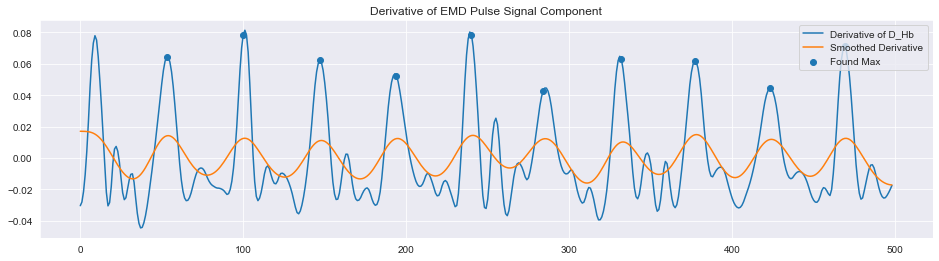

In [14]:
imf = emd.sift.sift(d_hb)
levels = (imf[:, 2]+imf[:, 3])[90*50:100*50]
dy = np.diff(levels)
ddy = np.diff(gaussian_filter1d(dy, 10))
pairs = []
zeros = []
maxes = []
first = -1
second = -1
for i in range(len(ddy) - 1):
    if ddy[i] <= 0 and ddy[i + 1] >= 0:
        first = i
    elif ddy[i] >= 0 and ddy[i + 1] <= 0 and first != -1:
        pairs.append((first, i))
        zeros.append(i)
        maxes.append(dy[i])
        first = -1
figure, axis = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(dy)
plt.plot(gaussian_filter1d(dy, 10))
plt.scatter(zeros, maxes)
plt.legend(["Derivative of D_Hb", "Smoothed Derivative", "Found Max"])
plt.title("Derivative of EMD Pulse Signal Component")
plt.show()

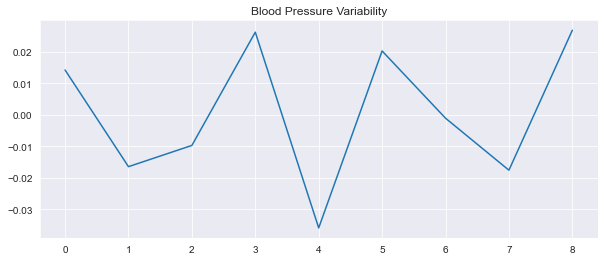

In [15]:
diffs = []
for i in range(len(maxes)-1):
    diffs.append((maxes[i+1] - maxes[i]))
figure, axis = plt.subplots(1, 1, figsize=(10, 4))
plt.plot(diffs)
plt.title("Blood Pressure Variability")
plt.show()

**Оценка вариабельности артериального давления для всего сигнала**

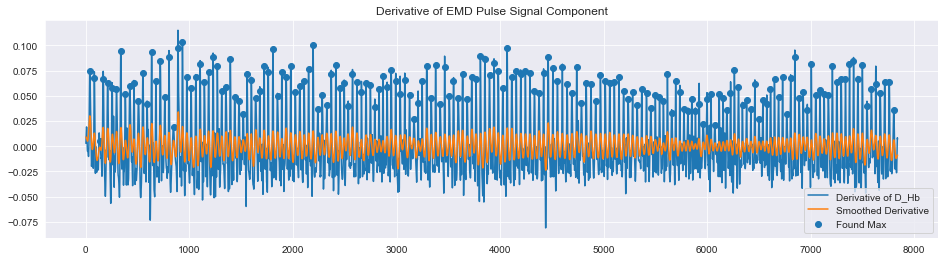

In [16]:
imf = emd.sift.sift(d_hb)
levels = imf[:, 2]+imf[:, 3]
dy = np.diff(levels)
ddy = np.diff(gaussian_filter1d(dy, 10))
pairs = []
zeros = []
maxes = []
first = -1
second = -1
for i in range(len(ddy) - 1):
    if ddy[i] <= 0 and ddy[i + 1] >= 0:
        first = i
    elif ddy[i] >= 0 and ddy[i + 1] <= 0 and first != -1:
        pairs.append((first, i))
        zeros.append(i)
        maxes.append(dy[i])
        first = -1
figure, axis = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(dy)
plt.plot(gaussian_filter1d(dy, 10))
plt.scatter(zeros, maxes)
plt.legend(["Derivative of D_Hb", "Smoothed Derivative", "Found Max"])
plt.title("Derivative of EMD Pulse Signal Component")
plt.show()

Гистограмма величин максимумов является информативной для обнаружения изменения давления. При изменении давления на графике возникает второй пик

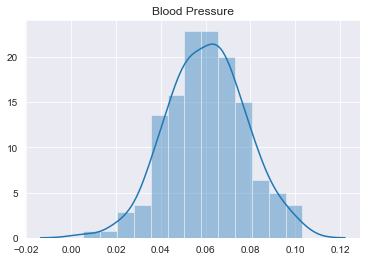

In [17]:
sns.distplot(maxes).set_title("Blood Pressure")
plt.show()

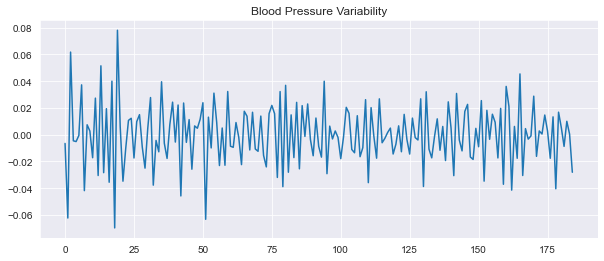

In [18]:
diffs = []
for i in range(len(maxes)-1):
    diffs.append((maxes[i+1] - maxes[i]))
figure, axis = plt.subplots(1, 1, figsize=(10, 4))
plt.plot(diffs)
plt.title("Blood Pressure Variability")
plt.show()

<a id='sat'></a>
### Вычисление артериальной и венозной сатурации
[Вернуться к содержанию](#contents)

Артериальная и венозная сатурация вычисляются по формулам:

\begin{equation}
    S_aO_2 = \frac{100[\epsilon_{HHb}(\lambda_1) - \epsilon_{HHb}(\lambda_2)(\frac{\Delta \mu a_{пульс}^{\lambda_1}}{\Delta \mu a_{пульс}^{\lambda_2}})]}{[\epsilon_{HHb}(\lambda_1) - \epsilon_{HbO}(\lambda_1)]-[\epsilon_{HHb}(\lambda_2) - \epsilon_{HbO}(\lambda_2)](\frac{\Delta \mu a_{пульс}^{\lambda_1}}{\Delta \mu a_{пульс}^{\lambda_2}})},
\end{equation}

\begin{equation}
    S_vO_2 = \frac{100[\epsilon_{HHb}(\lambda_1) - \epsilon_{HHb}(\lambda_2)(\frac{\Delta \mu a_{дыхат}^{\lambda_1}}{\Delta \mu a_{дыхат}^{\lambda_2}})]}{[\epsilon_{HHb}(\lambda_1) - \epsilon_{HbO}(\lambda_1)]-[\epsilon_{HHb}(\lambda_2) - \epsilon_{HbO}(\lambda_2)](\frac{\Delta \mu a_{дыхат}^{\lambda_1}}{\Delta \mu a_{дыхат}^{\lambda_2}})},
\end{equation}

где $\Delta \mu a_{пульс}^{\lambda_i}$ и $\Delta \mu a_{дыхат}^{\lambda_i}$ вычисляются как амплитуды пульсовой и дыхательной компоненты соответственно на графике преобразования Фурье для d_muA, вычисленного для источника с длиной волны $\lambda_i$

**Вычисление артериальной сатурации**

Вычисление d_muA для длин волн $\lambda_1$ и $\lambda_2$ и расстояния $r_1$ на участке, где основная компонента - пульсовая

In [5]:
filename = 'data/hypothenar_data.xlsx'
r_1 = 1.62
r_2 = 2.22
lmbd_1 = 692
lmbd_2 = 834

In [6]:
df = pd.read_excel(filename)
dc_1 = df["DC 1 A"].values # сигнал, записанный для lmbd2, r1
dc_5 = df["DC 5 A"].values # lmbd1, r1
eps_hhb = {692: 4.7564, 834: 1.7891} #табличные значения для возможных длин волн
eps_hbo = {692: 0.9558, 834: 2.3671}
dpf = 5.9 # табличное значение
d_mua_1 = (1 / (r_1 * dpf)) * np.log(dc_1[0] / dc_1)
d_mua_5 = (1 / (r_1 * dpf)) * np.log(dc_5[0] / dc_5)

Графики полученных сигналов

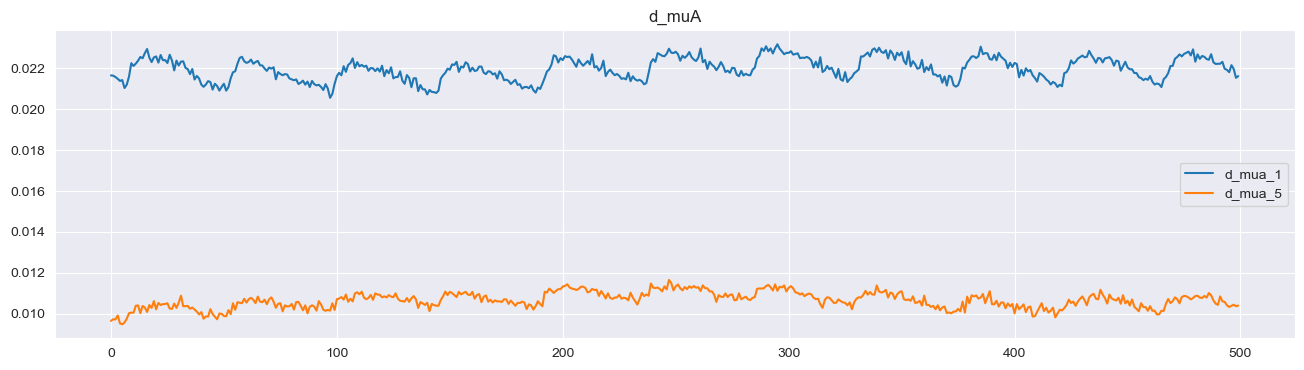

In [7]:
figure, axis = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(d_mua_1[90*50:100*50])
plt.plot(d_mua_5[90*50:100*50])
plt.legend(["d_mua_1", "d_mua_5"])
plt.title("d_muA")
plt.show()

Графики полученных сигналов и их преобразование Фурье

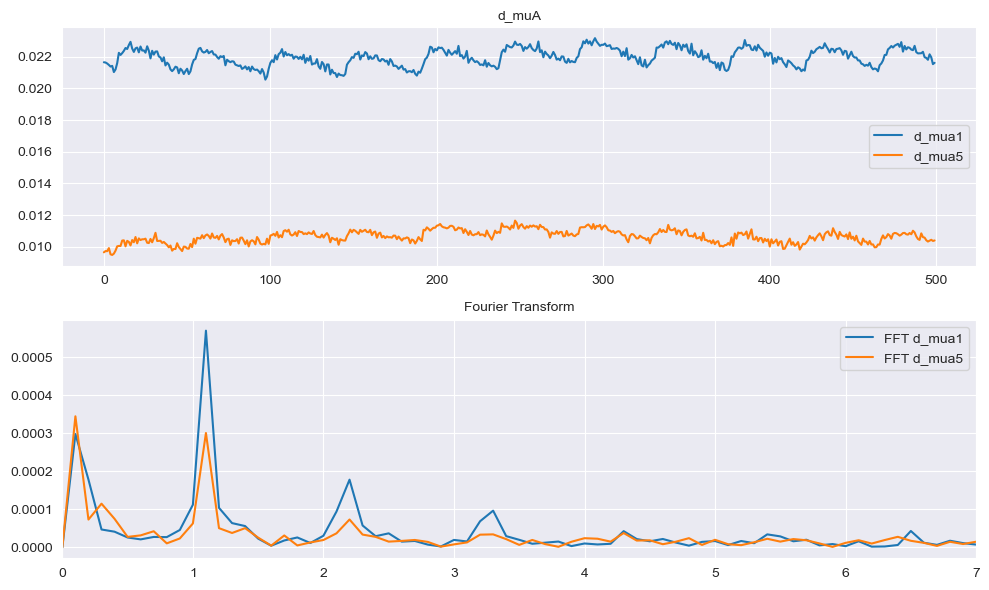

In [8]:
curr_dmua1 = d_mua_1[90*50:100*50]
curr_dmua5 = d_mua_5[90*50:100*50]

N = len(curr_dmua1)
spacing = 1 / 50
fourierTransform = fft(curr_dmua1 - np.average(curr_dmua1))
frequencies = fftfreq(N, spacing)[: N // 2]

figure, axis = plt.subplots(2, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('d_muA', fontsize=10)
axis[0].plot(curr_dmua1)

axis[1].set_title('Fourier Transform', fontsize=10)
axis[1].plot(frequencies, 2.0 / N * np.abs(fourierTransform[0 : N // 2]))

N = len(curr_dmua5)
spacing = 1 / 50
fourierTransform = fft(curr_dmua5 - np.average(curr_dmua5))
frequencies = fftfreq(N, spacing)[: N // 2]

axis[0].plot(curr_dmua5)

axis[1].plot(frequencies, 2.0 / N * np.abs(fourierTransform[0 : N // 2]))
axis[1].set_xlim(0, 7)

axis[0].legend(["d_mua1", "d_mua5"])

axis[1].legend(["FFT d_mua1", "FFT d_mua5"])

plt.tight_layout()
plt.show()

Поиск максимумов

In [9]:
curr_dmua1 = d_mua_1[90*50:100*50]

N = len(curr_dmua1)
spacing = 1 / 50
fourierTransform = fft(curr_dmua1 - np.average(curr_dmua1))
frequencies = fftfreq(N, spacing)[: N // 2]
fourierT = 2.0 / N * np.abs(fourierTransform[0 : N // 2])[:51]
max_dmua1 = np.max(fourierT[5:15])

curr_dmua5 = d_mua_5[90*50:100*50]

N = len(curr_dmua5)
spacing = 1 / 50
fourierTransform = fft(curr_dmua5 - np.average(curr_dmua5))
frequencies = fftfreq(N, spacing)[: N // 2]
fourierT = 2.0 / N * np.abs(fourierTransform[0 : N // 2])[:51]
max_dmua5 = np.max(fourierT[5:15])

Вычисление артериальной сатурации по формуле

In [10]:
sao2 = (eps_hhb[lmbd_1] - eps_hhb[lmbd_2] * (max_dmua5 / max_dmua1)) * 100
sao2 /= ((eps_hhb[lmbd_1] - eps_hbo[lmbd_1]) - (eps_hhb[lmbd_2] - eps_hbo[lmbd_2]) * \
                (max_dmua5 / max_dmua1))

In [11]:
print("Артериальная сатурация:", np.round(sao2, 1))

Артериальная сатурация: 92.8


**Вычисление венозной сатурации**

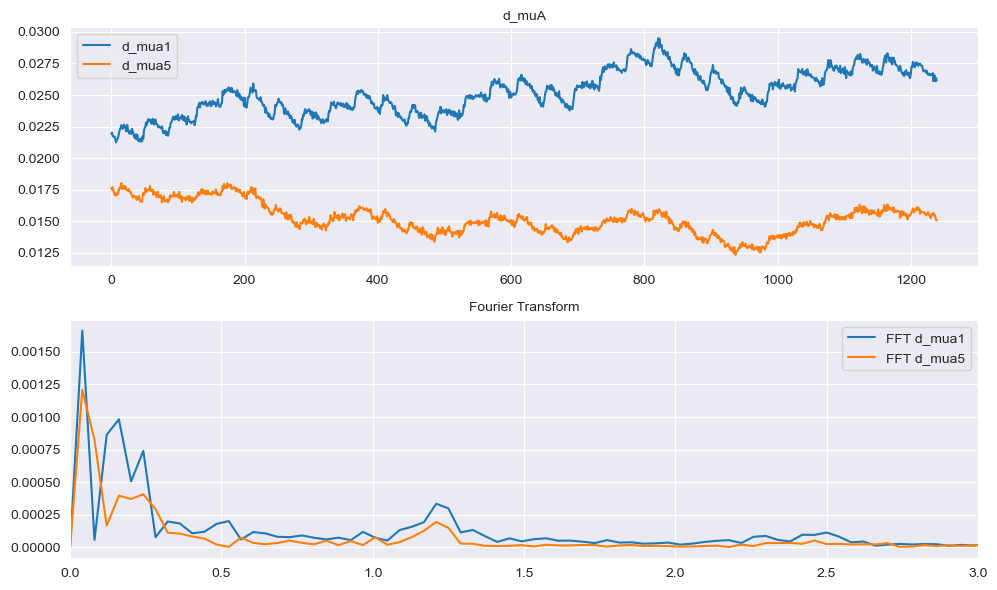

In [12]:
curr_dmua1 = d_mua_1[90*50+2100:]
curr_dmua5 = d_mua_5[90*50+2100:]

N = len(curr_dmua1)
spacing = 1 / 50
fourierTransform = fft(curr_dmua1 - np.average(curr_dmua1))
frequencies = fftfreq(N, spacing)[: N // 2]

figure, axis = plt.subplots(2, 1, figsize=(10, 6))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('d_muA', fontsize=10)
axis[0].plot(curr_dmua1)

axis[1].set_title('Fourier Transform', fontsize=10)
axis[1].plot(frequencies, 2.0 / N * np.abs(fourierTransform[0 : N // 2]))
axis[1].set_xlim(0, 3)

N = len(curr_dmua5)
spacing = 1 / 50
fourierTransform = fft(curr_dmua5 - np.average(curr_dmua5))
frequencies = fftfreq(N, spacing)[: N // 2]

axis[0].plot(curr_dmua5)

axis[1].plot(frequencies, 2.0 / N * np.abs(fourierTransform[0 : N // 2]))
axis[1].set_xlim(0, 3)

axis[0].legend(["d_mua1", "d_mua5"])

axis[1].legend(["FFT d_mua1", "FFT d_mua5"])

plt.tight_layout()
plt.show()

In [13]:
curr_dmua1 = d_mua_1[90*50+2100:]

N = len(curr_dmua1)
spacing = 1 / 50
fourierTransform = fft(curr_dmua1 - np.average(curr_dmua1))
frequencies = fftfreq(N, spacing)[: N // 2]
fourierT = 2.0 / N * np.abs(fourierTransform[0 : N // 2])[:51]
max_dmua1 = np.max(fourierT[5])

curr_dmua5 = d_mua_5[90*50+2100:]

N = len(curr_dmua5)
spacing = 1 / 50
fourierTransform = fft(curr_dmua5 - np.average(curr_dmua5))
frequencies = fftfreq(N, spacing)[: N // 2]
fourierT = 2.0 / N * np.abs(fourierTransform[0 : N // 2])[:51]
max_dmua5 = np.max(fourierT[5])

In [14]:
svo2 = (eps_hhb[lmbd_1] - eps_hhb[lmbd_2] * (max_dmua5 / max_dmua1)) * 100
svo2 /= ((eps_hhb[lmbd_1] - eps_hbo[lmbd_1]) - (eps_hhb[lmbd_2] - eps_hbo[lmbd_2]) * \
                (max_dmua5 / max_dmua1))
print("Венозная сатурация:", np.round(svo2, 1))

Венозная сатурация: 81.6


In [15]:
print("Артериально-венозная разница по кислороду:", np.round(sao2-svo2, 1))

Артериально-венозная разница по кислороду: 11.3


<a id='recover'></a>
### Основные параметры оксигенации и восстановление абсолютных значений
[Вернуться к содержанию](#contents)

In [18]:
#filename - название файла, записанного оксиметром, r_1 и r_2 - расстояния между источниками и приемником
def get_signals(filename, r_1, r_2, lmbd_1, lmbd_2): #lmbd_1 и lmbd_2 - длины волн источников
    df = pd.read_excel(filename)
    dc_1 = df["DC 1 A"].values # сигнал, записанный для lmbd2, r1
    dc_3 = df["DC 3 A"].values # lmbd2, r2
    dc_5 = df["DC 5 A"].values # lmbd1, r1
    dc_7 = df["DC 7 A"].values # lmbd1, r2
    time = df["Time"].values # временные отметки измерений
    eps_hhb = {692: 4.7564, 834: 1.7891} #табличные значения для возможных длин волн
    eps_hbo = {692: 0.9558, 834: 2.3671}
    sl = dict() # значения Sl_DC
    sl[lmbd_1] = (np.log(dc_7 / dc_5) + 2 * np.log(r_2 / r_1)) / (r_2 - r_1)
    sl[lmbd_2] = (np.log(dc_3 / dc_1) + 2 * np.log(r_2 / r_1)) / (r_2 - r_1)
    sto2 = (eps_hhb[lmbd_1] - eps_hhb[lmbd_2] * np.square(sl[lmbd_1] / sl[lmbd_2])) * 100
    sto2 /= ((eps_hhb[lmbd_1] - eps_hbo[lmbd_1]) - (eps_hhb[lmbd_2] - eps_hbo[lmbd_2]) * \
                    np.square(sl[lmbd_1] / sl[lmbd_2]))
    dpf = 5.9 # табличное значение
    d_mua_1 = (1 / (r_1 * dpf)) * np.log(dc_1[0] / dc_1)
    d_mua_3 = (1 / (r_2 * dpf)) * np.log(dc_3[0] / dc_3)
    d_mua_lmbd2 = (d_mua_1 + d_mua_3) / 2
    d_mua_5 = (1 / (r_1 * dpf)) * np.log(dc_5[0] / dc_5)
    d_mua_7 = (1 / (r_2 * dpf)) * np.log(dc_7[0] / dc_7)
    d_mua_lmbd1 = (d_mua_5 + d_mua_7) / 2
    d_hbo = (d_mua_lmbd2 * eps_hhb[lmbd_1] - d_mua_lmbd1 * eps_hhb[lmbd_2]) / \
    (eps_hbo[lmbd_2] * eps_hhb[lmbd_1] - eps_hbo[lmbd_1] * eps_hhb[lmbd_2]) * 1000
    d_hhb = (d_mua_lmbd1 * eps_hbo[lmbd_2] - d_mua_lmbd2 * eps_hbo[lmbd_1]) / \
    (eps_hbo[lmbd_2] * eps_hhb[lmbd_1] - eps_hbo[lmbd_1] * eps_hhb[lmbd_2]) * 1000
    d_thb = d_hbo + d_hhb
    d_hb = d_hbo - d_hhb
    return sto2, d_hb, d_hbo, d_hhb, d_thb, time, d_mua_lmbd1, d_mua_lmbd2

Вычисление изменений основных параметров оксигенации

In [19]:
sto2, d_hb, d_hbo, d_hhb, d_thb, time, d_mua_lmbd1, d_mua_lmbd2 = get_signals(filename, r_1, r_2, lmbd_1, lmbd_2)

Загрузка реальных абсолютных значений для сравнения

In [22]:
df_real = pd.read_excel('data/Diodes1357_HbUa.xlsx')
thb_real = df_real["THC A"].values
hhb_real = df_real[" [De Oxy] A"].values
hbo_real = df_real[" [Oxy] A"].values

Восстановление абсолютных значений

In [20]:
start_point = 250
total_slope = []
for i in range(len(sto2) - start_point):
    coeffs = np.polyfit(sto2[:start_point+i], d_hb[:start_point+i], 1)
    k = coeffs[0]
    total_slope.append(k)
smooth = gaussian_filter1d(total_slope[:1000], 20)

In [21]:
dy = np.diff(smooth) # поиск производной
index_max = np.argmax(dy) # индекс максимума
selected = 250 + index_max
sel_slope = total_slope[index_max]

t_hb0 = sel_slope * 50
print(sel_slope)
found_thb = d_thb + (t_hb0 - d_thb[selected])

0.9263877801847901


Точность восстановления

Среднее относительного отклонения (%): 0.35
СКО отклонения (%): 1.59


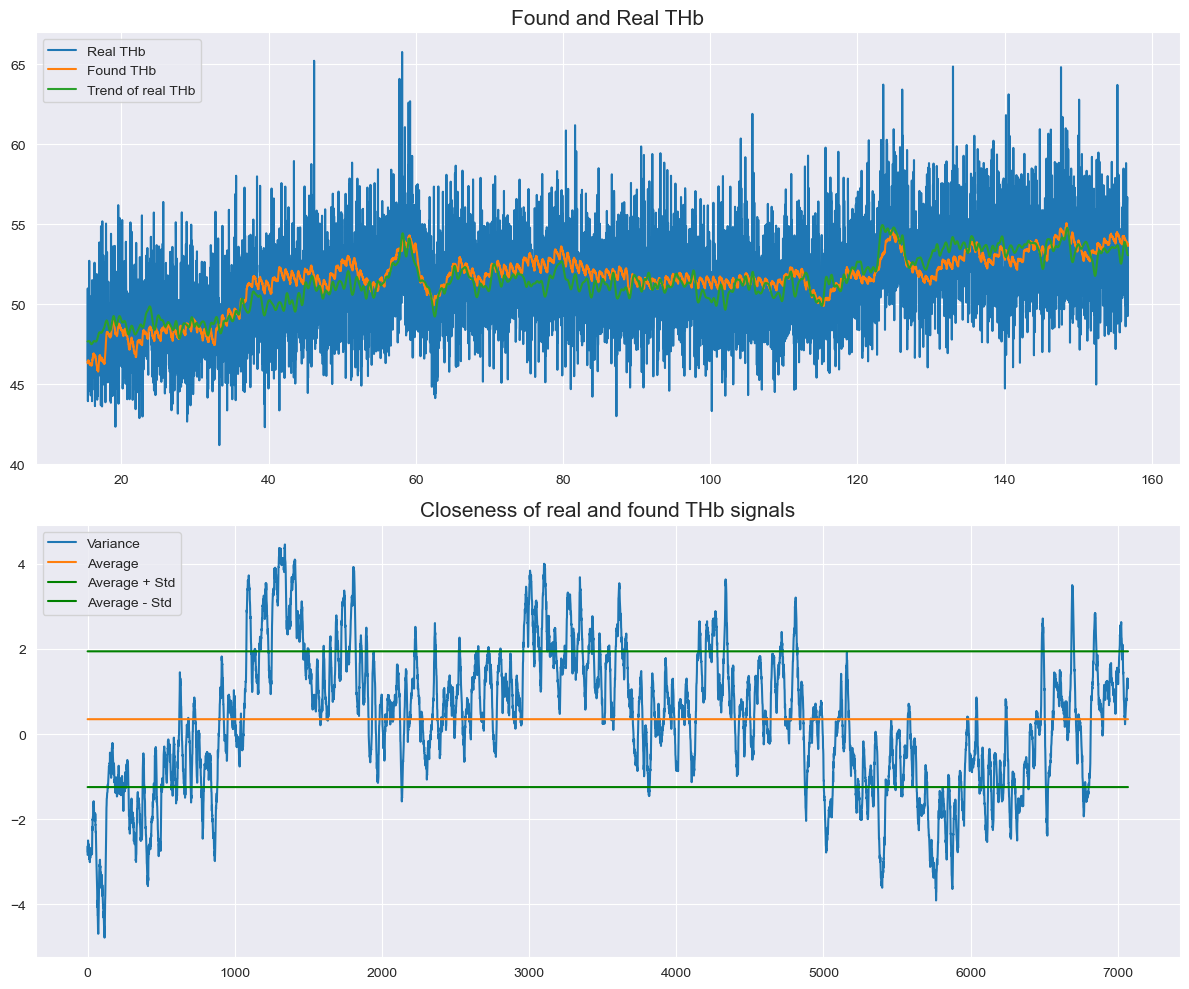

In [23]:
figure, axis = plt.subplots(2, 1, figsize=(12, 10))
#plt.subplots_adjust(hspace=1.0)
axis[0].set_title('Found and Real THb', fontsize=15)
axis[0].plot(time[selected:], thb_real[selected:])
axis[0].plot(time[selected:], found_thb[selected:])
axis[0].plot(time[selected:], gaussian_filter1d(thb_real[selected:], 10))
axis[0].legend(["Real THb", "Found THb", "Trend of real THb"])

trend_real = gaussian_filter1d(thb_real[selected:], 10)
variance = ((found_thb[selected:] - trend_real) / trend_real) * 100
aver = np.average(variance)
stdv = np.std(variance)

print("Среднее относительного отклонения (%):", np.round(aver, 2))
print("СКО отклонения (%):", np.round(stdv, 2))

axis[1].set_title("Closeness of real and found THb signals", fontsize=15)
axis[1].plot(variance)
axis[1].plot([aver] * len(variance))
axis[1].plot([aver + stdv] * len(variance), color='g')
axis[1].plot([aver - stdv] * len(variance), color='g')
axis[1].legend(["Variance", "Average", "Average + Std", "Average - Std"])
plt.tight_layout()
plt.show()

In [24]:
hbo0 = 0.01 * sto2[selected] * t_hb0
found_hbo = d_hbo + (hbo0 - d_hbo[selected])

hhb0 = t_hb0 - hbo0
found_hhb = d_hhb + (hhb0 - d_hhb[selected])

<a id='all_others'></a>
### Расчет остальных показателей работы кровеносной системы
[Вернуться к содержанию](#contents)

Коэффициент утилизации O2

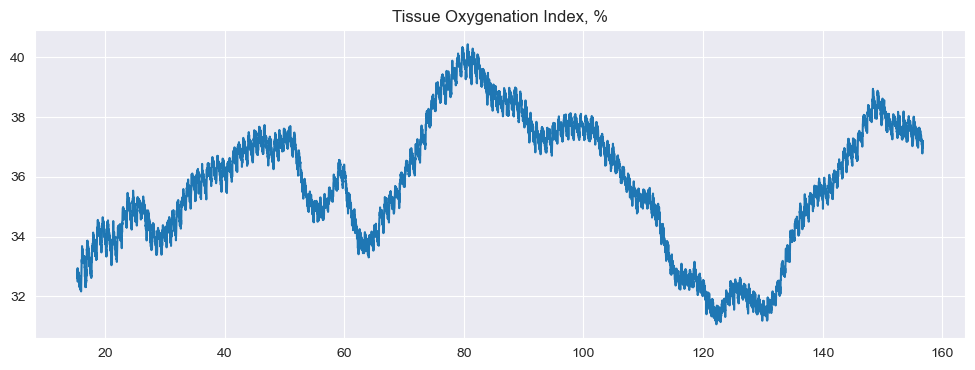

In [39]:
TOI = 100 * (np.array(found_hbo) - np.array(found_hhb)) / np.array(found_thb)

figure, axis = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time[selected:], TOI[selected:])
plt.title("Tissue Oxygenation Index, %")
plt.show()

In [53]:
np.mean(TOI[selected:])

35.73782735115739

Объем крови

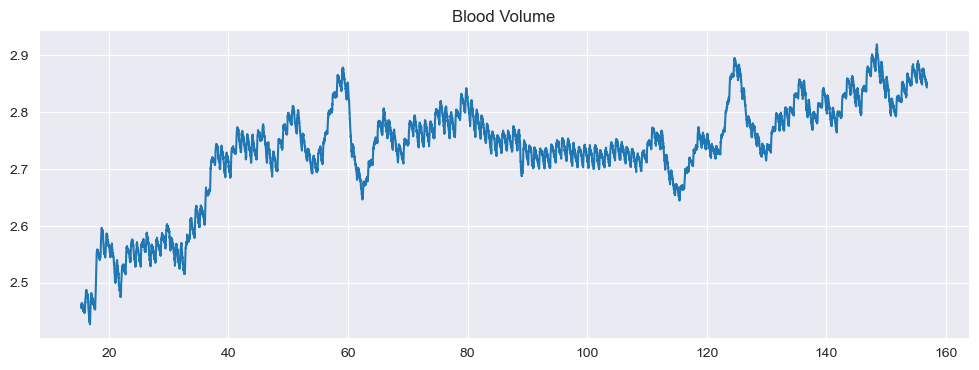

In [26]:
M_Hb = 64500
ro_t = 1.04
C_Hb = 11.7

BV = np.array(found_thb) * M_Hb / (ro_t * C_Hb * 100000)
figure, axis = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time[selected:], BV[selected:])
plt.title("Blood Volume")
plt.show()

In [54]:
np.mean(BV[selected:])

2.7339568617168553

Скорость кровотока

In [36]:
dTHb = np.gradient(found_thb)
window_points = 100
max_dTHb = []
for i in range(selected, len(dTHb)):
    max_dTHb.append(np.max(dTHb[i - 99:i+1]))

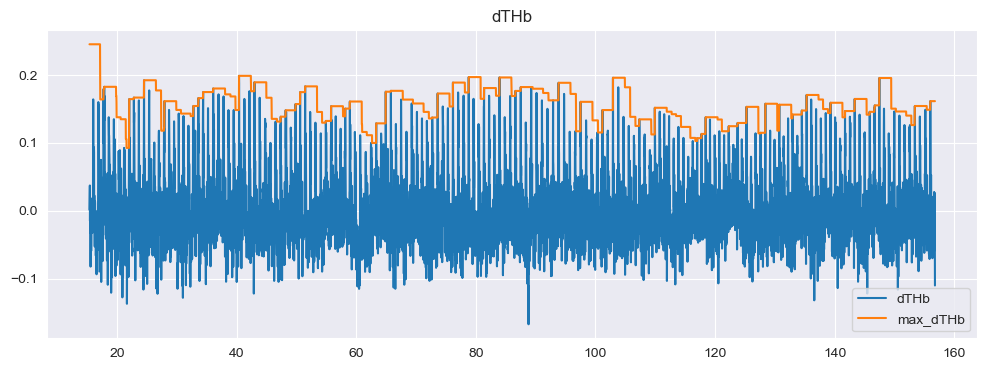

In [37]:
figure, axis = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time[selected:], dTHb[selected:])
plt.plot(time[selected:], max_dTHb)
plt.legend(["dTHb", "max_dTHb"])
plt.title("dTHb")
plt.show()

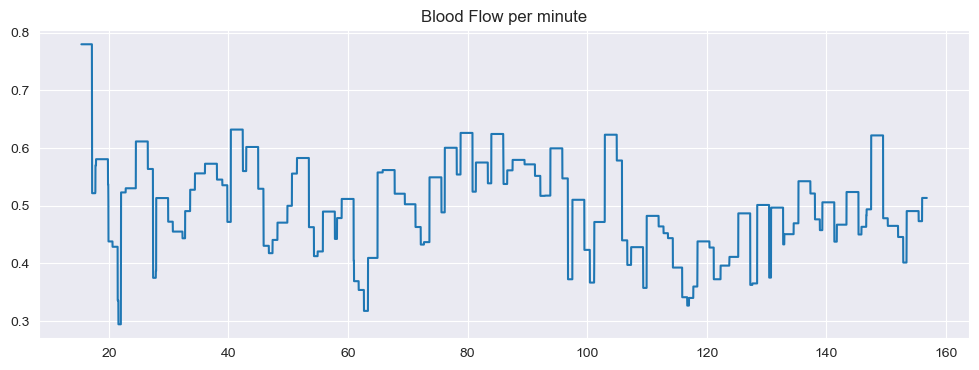

In [41]:
BF = np.array(max_dTHb) * M_Hb * 60 / (ro_t * C_Hb * 100000)
figure, axis = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time[selected:], BF)
plt.title("Blood Flow per minute")
plt.show()

In [52]:
np.mean(np.array(max_dTHb) * M_Hb * 60 / (ro_t * C_Hb * 100000))

0.5044942152570014

Средний уровень потребления кислорода тканью

In [44]:
BF = np.array(max_dTHb) * M_Hb / (ro_t * C_Hb * 100000)

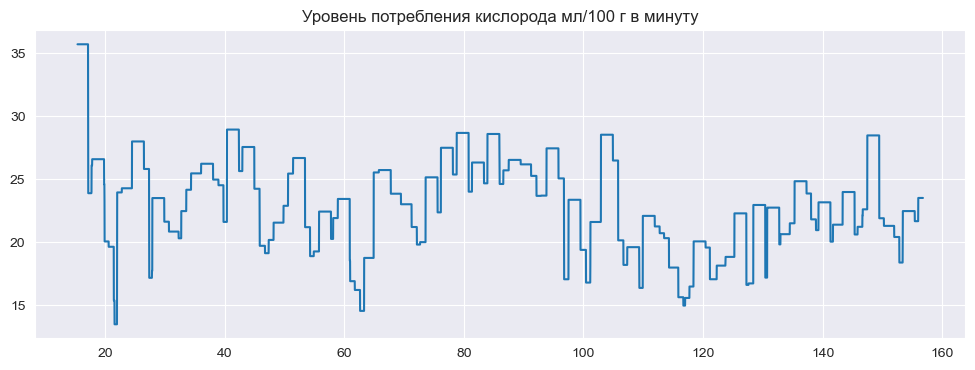

In [47]:
v_m = 22.4
mro2 = 1000 * 60 * C_Hb * BF * (sao2 - svo2) * v_m / M_Hb

figure, axis = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time[selected:], mro2)
plt.title("Уровень потребления кислорода мл/100 г в минуту")
plt.show()

In [55]:
np.mean(mro2)

23.087970246078477

In [49]:
dTHb = np.gradient(found_thb)
window_points = 100
avg_dTHb = []
for i in range(selected, len(dTHb)):
    avg_dTHb.append(np.mean(dTHb[i - 99:i+1]))

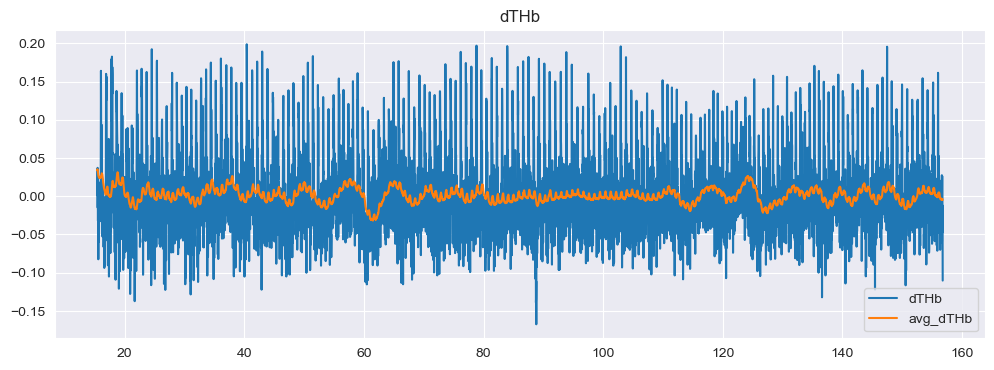

In [50]:
figure, axis = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time[selected:], dTHb[selected:])
plt.plot(time[selected:], avg_dTHb)
plt.legend(["dTHb", "avg_dTHb"])
plt.title("dTHb")
plt.show()